In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from matplotlib import pyplot
from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
mod = pd.read_csv("model.csv",  parse_dates=["DATEPRD"], index_col="DATEPRD")

In [3]:
mod

,BORE_OIL_VOL,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_GAS_VOL,F_4_ON_STREAM_HRS,F_4_BORE_WI_VOL,F_5_ON_STREAM_HRS,F_5_BORE_WI_VOL
DATEPRD,,,,,,,,,,,,
2010-01-01,18593.749401,24.0,3378.643673,223.079164,749.568621,190.264943,271.390953,1.462166e+07,24.0,44109.287732,24.0,49054.221066
2010-01-02,18701.242265,24.0,3377.769461,223.095696,744.664780,190.708397,266.368677,1.469266e+07,24.0,41936.969541,24.0,51515.296516
2010-01-03,17799.912406,24.0,3408.561097,223.074953,774.827418,192.268341,299.398157,1.400904e+07,24.0,41114.572918,24.0,51717.286427
2010-01-04,17002.616014,24.0,3439.266918,223.022721,806.160543,191.994925,333.246980,1.341015e+07,24.0,40267.292699,24.0,51948.640243
2010-01-05,17270.939334,24.0,3429.064568,223.035833,792.735696,191.503603,318.470614,1.361768e+07,24.0,40524.238503,24.0,52129.744099
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-19,1662.711432,24.0,3847.013385,211.367931,446.876829,190.761010,32.394472,1.366424e+06,24.0,27765.068530,24.0,26704.126695
2015-03-20,1707.494884,24.0,3846.666639,211.352287,446.242576,190.577844,31.563179,1.397308e+06,24.0,26112.632371,24.0,27951.162219
2015-03-21,1725.420844,24.0,3846.286199,211.349048,446.048129,191.111429,31.526865,1.408435e+06,24.0,26281.191015,24.0,27980.731217


In [4]:
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [5]:
# frame as supervised learning
reframed_unscaled = series_to_supervised(mod, mod.columns, 3, 1)
reframed_unscaled

,BORE_OIL_VOL(t-3),ON_STREAM_HRS(t-3),AVG_DOWNHOLE_PRESSURE(t-3),AVG_DOWNHOLE_TEMPERATURE(t-3),AVG_WHP_P(t-3),AVG_WHT_P(t-3),DP_CHOKE_SIZE(t-3),BORE_GAS_VOL(t-3),F_4_ON_STREAM_HRS(t-3),F_4_BORE_WI_VOL(t-3),...,AVG_DOWNHOLE_PRESSURE(t),AVG_DOWNHOLE_TEMPERATURE(t),AVG_WHP_P(t),AVG_WHT_P(t),DP_CHOKE_SIZE(t),BORE_GAS_VOL(t),F_4_ON_STREAM_HRS(t),F_4_BORE_WI_VOL(t),F_5_ON_STREAM_HRS(t),F_5_BORE_WI_VOL(t)
DATEPRD,,,,,,,,,,,,,,,,,,,,,
2010-01-04,18593.749401,24.0,3378.643673,223.079164,749.568621,190.264943,271.390953,1.462166e+07,24.0,44109.287732,...,3439.266918,223.022721,806.160543,191.994925,333.246980,1.341015e+07,24.0,40267.292699,24.0,51948.640243
2010-01-05,18701.242265,24.0,3377.769461,223.095696,744.664780,190.708397,266.368677,1.469266e+07,24.0,41936.969541,...,3429.064568,223.035833,792.735696,191.503603,318.470614,1.361768e+07,24.0,40524.238503,24.0,52129.744099
2010-01-06,17799.912406,24.0,3408.561097,223.074953,774.827418,192.268341,299.398157,1.400904e+07,24.0,41114.572918,...,3426.456339,223.052301,787.778892,191.155238,313.483219,1.364834e+07,24.0,40733.215195,24.0,52212.108216
2010-01-07,17002.616014,24.0,3439.266918,223.022721,806.160543,191.994925,333.246980,1.341015e+07,24.0,40267.292699,...,3432.314222,223.052885,791.388814,190.547894,317.780795,1.350971e+07,24.0,39969.857579,24.0,51109.971510
2010-01-08,17270.939334,24.0,3429.064568,223.035833,792.735696,191.503603,318.470614,1.361768e+07,24.0,40524.238503,...,3432.123127,223.061205,788.842189,190.683690,315.702450,1.349732e+07,24.0,41079.035678,24.0,50933.111950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-19,1630.318908,24.0,3845.004225,211.376916,445.337809,187.498025,31.455818,1.344981e+06,24.0,27622.708539,...,3847.013385,211.367931,446.876829,190.761010,32.394472,1.366424e+06,24.0,27765.068530,24.0,26704.126695
2015-03-20,1649.125441,24.0,3846.127014,211.369640,445.020316,185.994031,31.001010,1.348689e+06,24.0,26885.294563,...,3846.666639,211.352287,446.242576,190.577844,31.563179,1.397308e+06,24.0,26112.632371,24.0,27951.162219
2015-03-21,1659.440731,24.0,3847.561863,211.368061,447.407719,191.386379,32.071174,1.354500e+06,24.0,27174.003165,...,3846.286199,211.349048,446.048129,191.111429,31.526865,1.408435e+06,24.0,26281.191015,24.0,27980.731217


In [6]:
reframed_unscaled.columns

Index(['BORE_OIL_VOL(t-3)', 'ON_STREAM_HRS(t-3)', 'AVG_DOWNHOLE_PRESSURE(t-3)',
       'AVG_DOWNHOLE_TEMPERATURE(t-3)', 'AVG_WHP_P(t-3)', 'AVG_WHT_P(t-3)',
       'DP_CHOKE_SIZE(t-3)', 'BORE_GAS_VOL(t-3)', 'F_4_ON_STREAM_HRS(t-3)',
       'F_4_BORE_WI_VOL(t-3)', 'F_5_ON_STREAM_HRS(t-3)',
       'F_5_BORE_WI_VOL(t-3)', 'BORE_OIL_VOL(t-2)', 'ON_STREAM_HRS(t-2)',
       'AVG_DOWNHOLE_PRESSURE(t-2)', 'AVG_DOWNHOLE_TEMPERATURE(t-2)',
       'AVG_WHP_P(t-2)', 'AVG_WHT_P(t-2)', 'DP_CHOKE_SIZE(t-2)',
       'BORE_GAS_VOL(t-2)', 'F_4_ON_STREAM_HRS(t-2)', 'F_4_BORE_WI_VOL(t-2)',
       'F_5_ON_STREAM_HRS(t-2)', 'F_5_BORE_WI_VOL(t-2)', 'BORE_OIL_VOL(t-1)',
       'ON_STREAM_HRS(t-1)', 'AVG_DOWNHOLE_PRESSURE(t-1)',
       'AVG_DOWNHOLE_TEMPERATURE(t-1)', 'AVG_WHP_P(t-1)', 'AVG_WHT_P(t-1)',
       'DP_CHOKE_SIZE(t-1)', 'BORE_GAS_VOL(t-1)', 'F_4_ON_STREAM_HRS(t-1)',
       'F_4_BORE_WI_VOL(t-1)', 'F_5_ON_STREAM_HRS(t-1)',
       'F_5_BORE_WI_VOL(t-1)', 'BORE_OIL_VOL(t)', 'ON_STREAM_HRS(t)',
       '

In [7]:
# drop columns we don't want to predict
reframed_unscaled.drop([ 'ON_STREAM_HRS(t)',
       'AVG_DOWNHOLE_PRESSURE(t)', 'AVG_DOWNHOLE_TEMPERATURE(t)',
       'AVG_WHP_P(t)', 'AVG_WHT_P(t)', 'DP_CHOKE_SIZE(t)', 'BORE_GAS_VOL(t)',
       'F_4_ON_STREAM_HRS(t)', 'F_4_BORE_WI_VOL(t)', 'F_5_ON_STREAM_HRS(t)',
       'F_5_BORE_WI_VOL(t)'], axis=1, inplace=True)
reframed_unscaled.head()

,BORE_OIL_VOL(t-3),ON_STREAM_HRS(t-3),AVG_DOWNHOLE_PRESSURE(t-3),AVG_DOWNHOLE_TEMPERATURE(t-3),AVG_WHP_P(t-3),AVG_WHT_P(t-3),DP_CHOKE_SIZE(t-3),BORE_GAS_VOL(t-3),F_4_ON_STREAM_HRS(t-3),F_4_BORE_WI_VOL(t-3),...,AVG_DOWNHOLE_TEMPERATURE(t-1),AVG_WHP_P(t-1),AVG_WHT_P(t-1),DP_CHOKE_SIZE(t-1),BORE_GAS_VOL(t-1),F_4_ON_STREAM_HRS(t-1),F_4_BORE_WI_VOL(t-1),F_5_ON_STREAM_HRS(t-1),F_5_BORE_WI_VOL(t-1),BORE_OIL_VOL(t)
DATEPRD,,,,,,,,,,,,,,,,,,,,,
2010-01-04,18593.749401,24.0,3378.643673,223.079164,749.568621,190.264943,271.390953,1.462166e+07,24.0,44109.287732,...,223.074953,774.827418,192.268341,299.398157,1.400904e+07,24.0,41114.572918,24.0,51717.286427,17002.616014
2010-01-05,18701.242265,24.0,3377.769461,223.095696,744.664780,190.708397,266.368677,1.469266e+07,24.0,41936.969541,...,223.022721,806.160543,191.994925,333.246980,1.341015e+07,24.0,40267.292699,24.0,51948.640243,17270.939334
2010-01-06,17799.912406,24.0,3408.561097,223.074953,774.827418,192.268341,299.398157,1.400904e+07,24.0,41114.572918,...,223.035833,792.735696,191.503603,318.470614,1.361768e+07,24.0,40524.238503,24.0,52129.744099,17331.761803
2010-01-07,17002.616014,24.0,3439.266918,223.022721,806.160543,191.994925,333.246980,1.341015e+07,24.0,40267.292699,...,223.052301,787.778892,191.155238,313.483219,1.364834e+07,24.0,40733.215195,24.0,52212.108216,17138.601719
2010-01-08,17270.939334,24.0,3429.064568,223.035833,792.735696,191.503603,318.470614,1.361768e+07,24.0,40524.238503,...,223.052885,791.388814,190.547894,317.780795,1.350971e+07,24.0,39969.857579,24.0,51109.971510,17127.657449


In [8]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaled = scaler.fit_transform(mod)

In [68]:
reframed_scaled= series_to_supervised(scaled, mod.columns, 3, 1)

In [69]:
# drop columns we don't want to predict
reframed_scaled.drop([ 'ON_STREAM_HRS(t)',
       'AVG_DOWNHOLE_PRESSURE(t)', 'AVG_DOWNHOLE_TEMPERATURE(t)',
       'AVG_WHP_P(t)', 'AVG_WHT_P(t)', 'DP_CHOKE_SIZE(t)', 'BORE_GAS_VOL(t)',
       'F_4_ON_STREAM_HRS(t)', 'F_4_BORE_WI_VOL(t)', 'F_5_ON_STREAM_HRS(t)',
       'F_5_BORE_WI_VOL(t)'], axis=1, inplace=True)
reframed_scaled

,BORE_OIL_VOL(t-3),ON_STREAM_HRS(t-3),AVG_DOWNHOLE_PRESSURE(t-3),AVG_DOWNHOLE_TEMPERATURE(t-3),AVG_WHP_P(t-3),AVG_WHT_P(t-3),DP_CHOKE_SIZE(t-3),BORE_GAS_VOL(t-3),F_4_ON_STREAM_HRS(t-3),F_4_BORE_WI_VOL(t-3),...,AVG_DOWNHOLE_TEMPERATURE(t-1),AVG_WHP_P(t-1),AVG_WHT_P(t-1),DP_CHOKE_SIZE(t-1),BORE_GAS_VOL(t-1),F_4_ON_STREAM_HRS(t-1),F_4_BORE_WI_VOL(t-1),F_5_ON_STREAM_HRS(t-1),F_5_BORE_WI_VOL(t-1),BORE_OIL_VOL(t)
3,0.929412,1.0,0.550090,0.938862,0.409477,0.939638,0.148411,0.912476,0.96,0.776252,...,0.938630,0.423368,0.951668,0.163779,0.874245,0.96,0.723550,0.96,0.861227,0.849878
4,0.934785,1.0,0.549704,0.939771,0.406781,0.942300,0.145655,0.916907,0.96,0.738023,...,0.935758,0.440599,0.950026,0.182352,0.836871,0.96,0.708640,0.96,0.865080,0.863291
5,0.889731,1.0,0.563323,0.938630,0.423368,0.951668,0.163779,0.874245,0.96,0.723550,...,0.936479,0.433216,0.947075,0.174244,0.849823,0.96,0.713161,0.96,0.868096,0.866331
6,0.849878,1.0,0.576904,0.935758,0.440599,0.950026,0.182352,0.836871,0.96,0.708640,...,0.937384,0.430490,0.944984,0.171507,0.851736,0.96,0.716839,0.96,0.869467,0.856676
7,0.863291,1.0,0.572392,0.936479,0.433216,0.947075,0.174244,0.849823,0.96,0.713161,...,0.937416,0.432475,0.941337,0.173865,0.843085,0.96,0.703405,0.96,0.851114,0.856129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,0.081492,1.0,0.756366,0.295323,0.242173,0.923023,0.016758,0.083935,0.96,0.486115,...,0.294836,0.243312,0.946372,0.017096,0.084529,0.96,0.478219,0.96,0.448916,0.083111
1840,0.082432,1.0,0.756862,0.294923,0.241999,0.913991,0.016508,0.084166,0.96,0.473138,...,0.294829,0.243020,0.942616,0.017273,0.085273,0.96,0.488621,0.96,0.444693,0.085349
1841,0.082947,1.0,0.757497,0.294836,0.243312,0.946372,0.017096,0.084529,0.96,0.478219,...,0.293968,0.242671,0.941516,0.016817,0.087200,0.96,0.459540,0.96,0.465460,0.086245
1842,0.083111,1.0,0.757254,0.294829,0.243020,0.942616,0.017273,0.085273,0.96,0.488621,...,0.293790,0.242564,0.944721,0.016797,0.087895,0.96,0.462507,0.96,0.465952,0.081008


In [70]:
# split into train and test sets
values = reframed_scaled.values
n_train_days = 365 * 4
train = values[:n_train_days, :]
test = values[n_train_days:, :]
print(train.shape, test.shape)

(1460, 37) (381, 37)


In [71]:
# split into input and outputs
n_features = len(mod.columns)
timesteps = 3
lag_features = timesteps * n_features

train_X, train_y = train[:, :lag_features], train[:, -1]
test_X, test_y = test[:, :lag_features], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

(1460, 36) 1460 (1460,)


In [103]:
# reshape input to be 3D [samples, timesteps, features]
samples_train =  train_X.shape[0]
samples_test = test_X.shape[0]
train_X = train_X.reshape((samples_train, timesteps, n_features))
test_X = test_X.reshape((samples_test, timesteps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1460, 2, 12) (1460,) (382, 2, 12) (382,)


In [108]:
def get_hyper_param(n_iteration):
  hyper_param = []  
  for i in range(n_iteration):
    current_params = []
    current_params.append(np.random.randint(1,4)) # num_hidden_layers
    current_params.append(np.random.randint(32,512)) # 'num_neurons'
    current_params.append(np.random.choice([1e-2, 1e-3, 1e-4, 1e-7, 1e-10])) # learning_rate
    current_params.append(np.random.randint(1,15)) # epochs
    current_params.append(np.random.randint(1,100)) # batch_size
    current_params.append(np.random.choice(['relu', 'tanh'])) # activation
    current_params.append(np.round(np.random.uniform(0, 0.5),1) )# Dropout_rate
    current_params.append(np.random.randint(1,20)) # timesteps
    hyper_param.append(current_params)
  return hyper_param
  
hyper_parameter = get_hyper_param(3)
hyper_parameter

[[1, 396, 0.001, 3, 4, 'tanh', 0.3],
 [3, 429, 1e-10, 7, 11, 'tanh', 0.3],
 [3, 319, 0.01, 2, 90, 'tanh', 0.2]]

In [91]:
#hyperparamter tuning
def fit_lstm_random():
  
  min_val_loss = 999
  for  num_hidden_layers, num_neurons, learning_rate, n_epochs, batch_size, activation, Dropout_rate, timesteps in hyper_parameter:
    print('num_hidden_layers', num_hidden_layers, 'num_neurons', num_neurons, 'lr',learning_rate, 'n_epochs', n_epochs, "batch_size", batch_size,
     'activation', activation, 'Dropout_rate', Dropout_rate, 'timesteps', timesteps)

    #feature engineering
    reframed_scaled= series_to_supervised(scaled, mod.columns, timesteps, 1)

    # drop columns we don't want to predict
    reframed_scaled.drop([ 'ON_STREAM_HRS(t)',
          'AVG_DOWNHOLE_PRESSURE(t)', 'AVG_DOWNHOLE_TEMPERATURE(t)',
          'AVG_WHP_P(t)', 'AVG_WHT_P(t)', 'DP_CHOKE_SIZE(t)', 'BORE_GAS_VOL(t)',
          'F_4_ON_STREAM_HRS(t)', 'F_4_BORE_WI_VOL(t)', 'F_5_ON_STREAM_HRS(t)',
          'F_5_BORE_WI_VOL(t)'], axis=1, inplace=True)

    # split into train and test sets
    values = reframed_scaled.values
    n_train_days = 365 * 4
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]

    # split into input and outputs
    n_features = len(mod.columns)
    lag_features = timesteps * n_features
    train_X, train_y = train[:, :lag_features], train[:, -1]
    test_X, test_y = test[:, :lag_features], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    samples_train =  train_X.shape[0]
    samples_test = test_X.shape[0]
    train_X = train_X.reshape((samples_train, timesteps, n_features))
    test_X = test_X.reshape((samples_test, timesteps, n_features))

    
  # for timesteps, num_hidden_layers, num_neurons, learning_rate, n_epochs, batch_size, activation, Dropout_rate in hyper_parameter:
  #   print('timesteps', timesteps, 'num_hidden_layers', num_hidden_layers, 'num_neurons', num_neurons, 'lr',learning_rate, 'n_epochs', n_epochs, "batch_size", batch_size,
     #'activation', activation, 'Dropout_rate', Dropout_rate)
    
    model = Sequential()

    if num_hidden_layers != 1:
  
      for num in range(num_hidden_layers-1):
        model.add(LSTM(num_neurons, Activation(activation) , input_shape=(timesteps, n_features), return_sequences=True))
        model.add(Dropout(Dropout_rate))
      model.add(LSTM(num_neurons, Activation(activation) , input_shape=(timesteps, n_features)))
      model.add(Dropout(Dropout_rate))

    else:
      model.add(LSTM(num_neurons, Activation(activation) , input_shape=(timesteps, n_features)))
      model.add(Dropout(Dropout_rate))
    model.add(Dense(1)) # fully connected layer
    model.compile(loss='mean_squared_error',optimizer= tf.keras.optimizers.legacy.Adam(learning_rate =learning_rate),metrics=['mse'])
    
    # fit network
    lstm_model = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    current_val_loss = lstm_model.history['val_loss'][-1]
    if current_val_loss < min_val_loss:
      min_val_loss = current_val_loss
      best_params = [ num_hidden_layers, num_neurons, learning_rate, n_epochs, batch_size, activation, Dropout_rate, timesteps]

  print('final best params',best_params)
  return {"best_params": str(best_params) , "MSE": np.round(min_val_loss, 5)}
  

In [89]:
# run the model and repeat the evaluation 
def run_model(n_repeats = 1):
    scores = [fit_lstm_random() for _ in range(n_repeats)]
    result = pd.DataFrame(scores)
    result = result.groupby("best_params").mean()
    return result

In [104]:

score = run_model(1)

num_hidden_layers 1 num_neurons 58 lr 1e-07 n_epochs 9 batch_size 94 activation tanh Dropout_rate 0.1 timesteps 6
Epoch 1/9
16/16 - 3s - loss: 0.1329 - mse: 0.1329 - val_loss: 0.0139 - val_mse: 0.0139 - 3s/epoch - 172ms/step
Epoch 2/9
16/16 - 0s - loss: 0.1314 - mse: 0.1314 - val_loss: 0.0139 - val_mse: 0.0139 - 219ms/epoch - 14ms/step
Epoch 3/9
16/16 - 0s - loss: 0.1326 - mse: 0.1326 - val_loss: 0.0139 - val_mse: 0.0139 - 218ms/epoch - 14ms/step
Epoch 4/9
16/16 - 0s - loss: 0.1330 - mse: 0.1330 - val_loss: 0.0140 - val_mse: 0.0140 - 221ms/epoch - 14ms/step
Epoch 5/9
16/16 - 0s - loss: 0.1333 - mse: 0.1333 - val_loss: 0.0140 - val_mse: 0.0140 - 216ms/epoch - 14ms/step
Epoch 6/9
16/16 - 0s - loss: 0.1317 - mse: 0.1317 - val_loss: 0.0140 - val_mse: 0.0140 - 216ms/epoch - 13ms/step
Epoch 7/9
16/16 - 0s - loss: 0.1310 - mse: 0.1310 - val_loss: 0.0140 - val_mse: 0.0140 - 232ms/epoch - 15ms/step
Epoch 8/9
16/16 - 0s - loss: 0.1305 - mse: 0.1305 - val_loss: 0.0141 - val_mse: 0.0141 - 216ms/ep

In [105]:
score

,MSE
best_params,
"[1, 55, 0.0001, 13, 85, 'tanh', 0.4, 8]",0.02028


Epoch 1/50
21/21 - 4s - loss: 0.0875 - val_loss: 0.0016 - 4s/epoch - 194ms/step
Epoch 2/50
21/21 - 0s - loss: 0.0758 - val_loss: 0.0366 - 288ms/epoch - 14ms/step
Epoch 3/50
21/21 - 0s - loss: 0.0151 - val_loss: 0.0042 - 284ms/epoch - 14ms/step
Epoch 4/50
21/21 - 0s - loss: 0.0147 - val_loss: 0.0012 - 302ms/epoch - 14ms/step
Epoch 5/50
21/21 - 0s - loss: 0.0111 - val_loss: 0.0013 - 287ms/epoch - 14ms/step
Epoch 6/50
21/21 - 0s - loss: 0.0109 - val_loss: 0.0027 - 297ms/epoch - 14ms/step
Epoch 7/50
21/21 - 0s - loss: 0.0107 - val_loss: 0.0026 - 302ms/epoch - 14ms/step
Epoch 8/50
21/21 - 0s - loss: 0.0104 - val_loss: 0.0016 - 341ms/epoch - 16ms/step
Epoch 9/50
21/21 - 0s - loss: 0.0106 - val_loss: 0.0014 - 314ms/epoch - 15ms/step
Epoch 10/50
21/21 - 0s - loss: 0.0107 - val_loss: 0.0014 - 455ms/epoch - 22ms/step
Epoch 11/50
21/21 - 0s - loss: 0.0107 - val_loss: 0.0014 - 376ms/epoch - 18ms/step
Epoch 12/50
21/21 - 0s - loss: 0.0108 - val_loss: 0.0015 - 289ms/epoch - 14ms/step
Epoch 13/50
21/

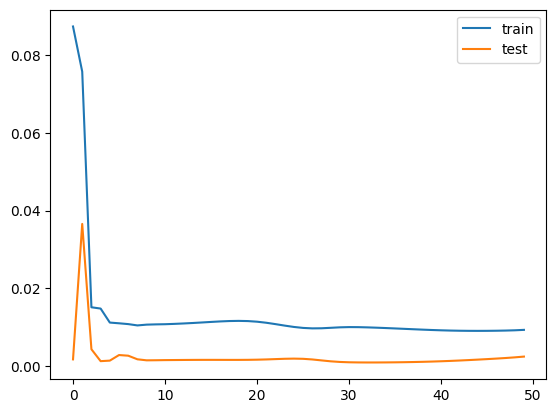

In [ ]:
# # design network
# model = Sequential()
# model.add(LSTM(150, input_shape=(timesteps, n_features)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# # fit network
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

In [ ]:
history.history['val_loss'][-1]

0.002347363391891122

In [ ]:
# # make a prediction
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], timesteps*n_features))
# # invert scaling for forecast
# inv_yhat = np.repeat(yhat, n_features, axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.repeat(test_y, n_features, axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# test_X = test_X.reshape((test_X.shape[0], timesteps, n_features))
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

12/12 [==============================] - 0s 4ms/step
Test RMSE: 969.280
